In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2022-spring/lab1-5.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 1-5 – Scaling up: Torchtext and PyTorch

As you've seen, a typical pipeline for NLP applications based on supervised machine learning involves several standard components:

1. Loading of annotated textual corpora.
2. Tokenization and normalization of the text.
3. Distributing instances into subcorpora, for instance, training, development, and test corpora.
4. Training of models on training data, using development data for model selection.
5. Evaluation of the models on test data.

Rather than recapitulate all of these component tasks for each application, standard packages have been developed to facilitate them. In order to facilitate your own experimentation, it's time to make use of some of these packages to scale up your ability to build and test models. That is the subject of this lab.

Torchtext datasets provide a uniform system for establishing dataset objects that contain multiple examples, each of which may have multiple named fields. These fields themselves have specifications that tell whether the data in that field is sequential (like text sequences) or simple (like class labels); whether and how to preprocess, tokenize, or postprocess the data; and many other properties. Dataset objects can be easily split into parts (training and test, for instance), or turned into a sequence of small batches for processing by models.

This lab provides an introduction to using `torchtext` and PyTorch in preparation for its appearance in later labs and homework problem sets.

After this lab, you should be able to

* Read `torchtext` code and understand what it is intending to accomplish.
* Run experiments training and testing simple feed-forward neural networks using PyTorch.

New bits of Python used for the first time in the *distribution version* of this lab include:

* TorchText
    * [`torchtext.data.TabularDataset`](https://pytorch.org/text/0.8.1/data.html#tabulardataset)
    * `torchtext.data.TabularDataset.split`
    * [`torchtext.data.Field`](https://pytorch.org/text/0.8.1/data.html#field)
    * `torchtext.data.Field.build_vocab`
    * `torchtext.data.Field.lower`
    * `torchtext.data.Field.sequential`
    * `torchtext.data.Field.tokenize`
    * `torchtext.data.Field.vocab`
    * `torchtext.data.Field.vocab.itos`
    * `torchtext.data.Field.vocab.stoi`

    > You'll notice that for `torchtext` we link to version 0.8.1 of the PyTorch documentation, because the `torchtext.data.Field` class is now deprecated. We therefore import it as `torchtext.legacy` at the top of this notebook. Sadly, `torchtext` has no convenient replacement for `Field` at the moment, so we resort to the legacy system.

* Torch

    * [`torch.nn.Module.eval`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)
    * `torch.nn.Linear`
    * `torch.nn.Sigmoid`
    * `torch.distributions.normal.Normal`
    * `torch.distributions.uniform.Uniform`


* `tqdm.tqdm` (for generating progress bars)

New bits of Python used for the first time in the *solution set* for this lab, and which you may therefore find useful:

* [`torch.Tensor.backward`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.backward)
* [`torch.optim.Optimizer.step`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step)

# Preparation – Loading packages and data

In [3]:
import copy
import math
import random
import matplotlib.pyplot as plt
import os
import re
import sys
import torch
import torch.distributions as ds
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy as tt
import warnings
import wget

from torch import optim
from tqdm import tqdm

In [4]:
# Set up plotting
plt.style.use('tableau-colorblind10')

# Fix random seed for replicability
random_seed = 1234
random.seed(random_seed)
torch.manual_seed(random_seed)

## GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Manipulating text corpora with `torchtext`

You'll use `torchtext` to load the _Green Eggs and Ham_ (GEaH) dataset.

We start with reading in the data and performing some ad hoc cleaning (removing comment lines and blank lines).

In [5]:
def strip_file(text):
    """strip #comments and empty lines from `text` string"""
    result = ""
    for line in text.split("\n"):
        line = line.strip()              # trim whitespace
        line = re.sub('#.*$', '', line)  # trim comments
        if line != '':                   # drop blank lines
            result += line + '\n'
    return result

# Read the GEaH data and write out a corresponding TSV file
os.makedirs('data', exist_ok=True)
wget.download("https://github.com/nlp-236299/data/raw/master/Seuss/seuss - 1960 - green eggs and ham.txt", out="data/")
with open('data/seuss - 1960 - green eggs and ham.txt', 'r') as fin:
    with open('data/geah.tsv', 'w') as fout:
        fout.write(strip_file(fin.read()))

## Constructing training and test datasets

Take a look at the file `geah.tsv`, which we've just processed and placed into the sibling `data` folder. 

In [6]:
shell('head "data/geah.tsv"')

SAM	I am Sam.
SAM	I am Sam.
SAM	Sam I am.
GUY	That Sam-I-am!
GUY	That Sam-I-am!
GUY	I do not like that Sam-I-am!
SAM	Do you like green eggs and ham?
GUY	I do not like them, Sam-I-am.
GUY	I do not like green eggs and ham.
SAM	Would you like them here or there?


Notice the structure of this corpus. Each line contains a sentence from the book, preceded by a label that provides the speaker of that sentence. The speaker and sentence are separated by a tab character. The data is thus set up properly for a [`torchtext.data.TabularDataset`](https://pytorch.org/text/0.8.1/data.html#tabulardataset) using its `"TSV"` (tab-separated values) format.

In order to establish a `torchtext.data.TabularDataset` object for dealing with the GEaH dataset, you'll first need to establish the two fields (via [`torchtext.data.Field`](https://pytorch.org/text/0.8.1/data.html#field)), one for the label (the speaker) and one for the text, which you should call `LABEL` and `TEXT`, respectively. These fields are used for mapping from strings to ids or vice versa.

When setting up a field with `torchtext.data.Field`, you'll want to consider whether you want to further specify the values for the various keyword arguments listed [here](https://pytorch.org/text/0.8.1/data.html#field), or to leave the default values.

With respect to the tokenization of the text field, you should use the `torchtext` "basic_english" tokenizer introduced in lab 1-1 for the text field and lowercase all tokens.
<!--
BEGIN QUESTION
name: fields_setup
-->

In [7]:
#TODO: Define one `tt.data.Field` for processing the label
#      and another for processing the text using the "basic_english"
#      tokenizer and **lowercase** all tokens

LABEL = (
    tt.data.Field(sequential = False)
)
    
TEXT = (
    tt.data.Field(sequential = True, tokenize = "basic_english", lower = True)
)

fields = [("label", LABEL), ("text", TEXT)]

In [8]:
grader.check("fields_setup")

All tests passed!

Now, you can set up the dataset using [`torchtext.data.TabularDataset`](https://pytorch.org/text/0.8.1/data.html#tabulardataset). It should look for the TSV data in the file `data/geah.tsv`, and should use the `fields` defined above.
<!--
BEGIN QUESTION
name: dataset_setup
-->

In [9]:
#TODO: Set up the dataset using `tt.data.TabularDataset`
# Note that you need to use `fields` for fields.
geah = tt.data.TabularDataset('data/geah.tsv', 'TSV', fields)

In [10]:
grader.check("dataset_setup")

All tests passed!

All [`torchtext.data.Dataset`](https://pytorch.org/text/0.8.1/data.html#dataset) objects have a [`split`](https://pytorch.org/text/0.8.1/data.html#torchtext.data.Dataset.split) method that splits the dataset into two or three pieces, for instance, to have a separate training and test set. Use the `split` method to generate a 70%/30% split of the GEaH corpus into two subsets called `train` and `test`.
<!--
BEGIN QUESTION
name: dataset_split
-->

In [11]:
#TODO: Split geah into 70% training data and 30% test data
train, test = geah.split(split_ratio=0.7)

In [12]:
grader.check("dataset_split")

All tests passed!

Fields can have associated with them a _vocabulary_ consisiting of all of the possible values that are used in that field in a particular dataset. The vocabulary establishes the kind of indexing scheme between types and indices that we explored in lab 1-1. We will use the training corpus to establish vocabularies for the two fields `LABEL` and `TEXT` using the [`build_vocab`](https://pytorch.org/text/data.html#torchtext.data.Field.build_vocab) method.

In [13]:
LABEL.build_vocab(train.label)
TEXT.build_vocab(train.text)

The `TEXT` and `LABEL` fields, objects of class [`torchtext.data.Field`](https://pytorch.org/text/0.8.1/data.html#field), now have vocabularies associated with them, accessible in their respective `vocab` fields. How many elements are there in these vocabularies? You can use the `len` function to find out.
<!--
BEGIN QUESTION
name: vocab_sizes
-->

In [14]:
#TODO: Calculate the sizes of LABEL.vocab and TEXT.vocab
label_vocab_size = len(LABEL.vocab)
text_vocab_size = len(TEXT.vocab)


In [15]:
grader.check("vocab_sizes")

All tests passed!

In [16]:
print(f"label vocabulary size is {label_vocab_size}\n"
      f"text vocabulary size is {text_vocab_size}")

label vocabulary size is 3
text vocabulary size is 56


Why are there three elements in the `LABEL` vocabulary, given that there are only two speakers, Guy and Sam? We can find out by examining the `LABEL` vocabulary more closely. `Field` vocabulary objects have an especially useful `stoi` data field, whose value is a dictionary that maps the elements of the vocabulary to integer index representations of the elements. Let's take a look.

In [17]:
LABEL.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fc60400c850>>,
            {'<unk>': 0, 'GUY': 1, 'SAM': 2})

<!-- BEGIN QUESTION -->

**Question:** What is the unexpected third element in the label vocabulary? Why do you think it's there?
<!--
BEGIN QUESTION
name: open_response_third_element
manual: true
-->

_'< unk>' is the unexpected third element. its probably there so that we can access labels in a 1-indexed way._

<!-- END QUESTION -->



> As described in more detail in [the `torchtext` documentation](https://torchtext.readthedocs.io/en/latest/vocab.html#torchtext.vocab.Vocab), there's also an `itos` data field for conversion of vocabulary items from the index representation to the original values and a `freqs` data field that keeps a frequency distribution for the items in the vocabulary as a `collections.Counter` object.

## Operations over datasets

We now have training and test datasets. You can experiment with the kinds of operations you'll need to do to implement models like Naive Bayes or logistic regression.

For instance, you can inspect an example from the dataset.

In [18]:
example = train[1] # the second instance
print (f"text: {example.text}\n"
       f"label: {example.label}")

text: ['i', 'would', 'not', 'eat', 'them', 'anywhere', '.']
label: GUY


You might also need to iterate over the different class labels (the vocabulary of the `LABEL` field) or the word types (the vocabulary of the `TEXT` field). Define a function that iterates over the vocabulary of a field and prints each one out like this:

```
>>> print_vocab(LABEL)
<unk>
GUY
SAM
```

<!--
BEGIN QUESTION
name: print_vocab
-->

In [19]:
#TODO
def print_vocab(field):
    for label in field.vocab.stoi:
        print(label)

In [20]:
grader.check("print_vocab")

All tests passed!

 We can use the `print_vocab` function to print out the different class labels in the `LABEL` field.

In [21]:
print_vocab(LABEL)

<unk>
GUY
SAM


Other simple calculations that will be useful in implementing the various models:

1. Counting how many instances there are in a dataset.
2. Counting how many instances of a certain class there are in a dataset.
3. Counting how many tokens of a certain type there are in the text of an instance.

Let's write functions for these. They'll come in handy in the first problem set.

<!--
BEGIN QUESTION
name: count_instances
-->

In [22]:
#TODO - 1. Counting how many instances there are in a dataset.
def count_instances(dataset):
    return len(dataset)

In [23]:
grader.check("count_instances")

All tests passed!

In [24]:
#TODO - 2. Counting how many instances of a certain class there are in a dataset.
# Note: recall that you can access the label of an instance using `instance.label`
def count_instances_class(dataset, label):
    res = 0
    for instance in dataset:
        res += (instance.label == label)
    return res

In [25]:
grader.check("count_instances_class")

All tests passed!

In [26]:
#TODO - 3. Counting how many tokens of a certain type there are in the text of an instance.
# Note: recall that you can access the list of tokens using `instance.text`
def count_tokens_instance(instance, tokentype):
    res = 0
    for tok in instance.text:
        res += (tok == tokentype)
    return res

In [27]:
grader.check("count_tokens_instances")

All tests passed!

Recall that the purpose of fields is to map back and forth between strings and word ids. Below provides an example of how to do that.

In [28]:
example = train[1]
text = example.text
word_ids = [TEXT.vocab.stoi[word] for word in text]
print (f"Mapped to word ids: {word_ids}\n"
       f"Mapped back: {[TEXT.vocab.itos[id] for id in word_ids]}")
label = example.label
label_id = LABEL.vocab.stoi[label]
print (f"Label id: {label_id}\n"
       f"label: {LABEL.vocab.itos[label_id]}")

Mapped to word ids: [4, 14, 3, 15, 5, 26, 2]
Mapped back: ['i', 'would', 'not', 'eat', 'them', 'anywhere', '.']
Label id: 1
label: GUY


# Training and testing with PyTorch

Past labs have shown that all of the detail about 

* establishing models and their parameters,
* using them to calculate the outputs for some inputs, 
* training them to optimize the parameters via stochastic gradient descent, and 
* evaluating them by testing on held-out data

is tedious to manage. Fortunately, it is also so formulaic, at least for a certain class of models, that general tools can be deployed to manage the process. In the remainder of this lab, you'll use one such tool, PyTorch. For simplicity, rather than a natural-language task, you'll be training a model to fit a curve; it has an especially simple structure: one scalar input and one scalar output.

## Generating training and test data

We start by generating some training and test data. The data is generated as a noisy sine function, calculated by the function `sinusoid`. (Here we make use of the PyTorch [distributions](https://pytorch.org/docs/stable/distributions.html) package, which was imported above as `ds`.) 

In [29]:
def sinusoid(x, amplitude=1., phase=0., frequency=1., noise=1e-5):
    """Returns the values on input(s) `x` of a sinusoid determined by `amplitude`, 
       `phase`, and angular `frequency`, with some added normal noise with variance 
       given by `noise`."""
    normal_noise = ds.normal.Normal(torch.tensor([0.0]), torch.tensor([noise]))
    noise_sample = normal_noise.sample(x.size()).view(-1)
    y = amplitude * torch.sin(x * frequency + phase) + noise_sample
    return y

We can generate data for training and testing by sampling this function.

In [30]:
def sample_input(func, count, bound, **kwargs):
    """Returns `count` samples of x-y pairs of function `func`, with the x 
       values sampled uniformly between +/-`bound`. The `kwargs` are passed
       on to `func`."""
    input_unif = ds.uniform.Uniform(-bound, +bound)
    x = input_unif.sample(torch.Size([count]))
    y = func(x, **kwargs)
    return x, y

To give a sense of what a data sample looks like, we plot a sample of 100 points.

In [31]:
def plot_sample(data):
    """Plots `data` given as a single pair of inputs and outputs."""
    X, Y = data
    plt.plot(X.tolist(), Y.tolist(), '.')
    plt.xlabel('Input')
    plt.ylabel('Output')
    # we cannot use plt.show() because otter-grader does not support it

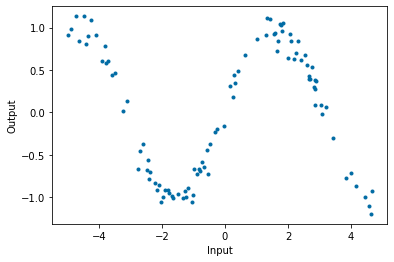

In [32]:
plot_sample(sample_input(sinusoid, 100, 5, noise=0.1))

## Specifying a feed-forward neural network


<img src="https://github.com/nlp-course/data/raw/master/Resources/ffnn-example.png" width=33% align=right />

The model that we will train to predict the output of this function based on a sample will consist of a series of sublayers as depicted in the figure at right. At the bottom of the figure, we start with $\vect{x}$, the scalar input (of dimensionality $1$ as shown in the "shape" designation). The first layer is a perceptron layer, composed of a linear sublayer (with weights $\vect{U}$) followed by a sigmoid sublayer. Since $\vect{U}$ is of dimensionality $1 \times D$, the output is a vector of dimensionality $D$. (We refer to $D$ as the *hidden dimension*.) Then comes another perceptron layer with input and output each of dimensionality $D$. Finally, a single linear layer reduces the dimensionality back to the predicted scalar output $\tilde{y}$ of dimensionality $1$. The loss is calculated as the mean square error of $\tilde{y}$ relative to $y$. (In this case, taking the mean for a single example is irrelevant, since $y$ is a scalar, though when training in "batches", the mean would be taken over the batch.)

We define a class `FFNN` (**f**eed-**f**orward **n**eural **n**etwork), which inherits from the `nn.Module` class, PyTorch's class for neural network models. It takes an argument `hidden_dim` which is the size of the hidden layers, $D$ in the figure.

The parameters of this model – the values that will be adjusted to minimize the loss – are the elements of the tensors $\vect{U}$, $\vect{V}$, and $\vect{W}$. They don't appear explicitly in the code, but are PyTorch *parameters* created and tracked when the corresponding sublayers are created using `nn.Linear`. That's the wonder of using PyTorch – so much happens under the hood. But we can get access to the parameters because the `nn.Module` class provides a `parameters` method that returns an iterator over the parameters. (We use it to initialize the parameters to random values.)

In [33]:
class FFNN(nn.Module):
    def __init__(self, hidden_dim, init_low=-2, init_high=2):
        super().__init__()
        # dimensionality of hidden layers
        self.hidden_dim = hidden_dim
        #TODO: establish the sublayers -- two perceptrons (each has a linear layer and a sigmoid). and a final
        # linear layer. Follow the dimensions from the description above.
        self.sublayer1 = nn.Linear(1,hidden_dim)
        self.sublayer2 = nn.Sigmoid()
        self.sublayer3 = nn.Linear(hidden_dim,hidden_dim)
        self.sublayer4 = nn.Sigmoid()
        self.sublayer5 = nn.Linear(hidden_dim,1)
        
        # initialize parameters randomly
        torch.manual_seed(random_seed)
        for p in self.parameters():
            p.data.uniform_(init_low, init_high)
        # save a copy of the parameters to allow resetting
        self.init_state = copy.deepcopy(self.state_dict())

    # Resetting state: If you want to rerun a model, say, with a different
    # training regime, you can reset the model's parameter state using
    #    model.reset_state()
    # before retraining, e.g., 
    #    train_model(model, criterion, optim, train_data, n_epochs=50)
    def reset_state(self):
        self.load_state_dict(self.init_state)
        
    def forward(self, x):
        # first perceptron layer
        z = self.sublayer2(self.sublayer1(x))
        # second perceptron layer
        z_prime = self.sublayer4(self.sublayer3(z))
        # final linear layer
        return self.sublayer5(z_prime)

In [34]:
grader.check("FFNN")

All tests passed!

We can build a model by instantiating the `FFNN` class. We'll do so with a hidden dimension of 4, being careful to move the model with its parameters to the device we're using for calculations (a GPU if one is available, as on Google Colab).

In [35]:
HIDDEN_DIMENSION = 4
model = FFNN(HIDDEN_DIMENSION).to(device)

We specify the criterion to be optimized as the mean square error loss function provided by PyTorch.

In [36]:
criterion = nn.MSELoss(reduction='mean') 

## Evaluating data according to a model

To evaluate how well the model performs on some test data, we run the model forward on the $x$ values and compute the loss relative to the $y$ values. We define a function `eval_model` to carry out this calculation.

In [37]:
def eval_model(model, criterion, data):
    """Applies the `model` to the x values in the `data` and returns the
       loss relative to the y values in the `data` along with the predicted 
       y values."""
    model.eval()                          # turn on evaluation mode
    with torch.no_grad():                 # turn off propagating gradients
        X, Y = data                       # extract x and y values
        X = X.view(-1, 1).to(device)      # convert x and y to column vectors
        Y = Y.view(-1, 1).to(device)      # ...and move them to the device
        predictions = model(X)            # calculate the predicted y values
        loss = criterion(predictions, Y)  # see how far off they are
    return loss.item(), predictions

All that remains is training the model. We'll use one of PyTorch's built in optimizers, the `Adam` optimizer. We set a few parameters for the training process: the learning rate, the number of "epochs" (passes through the training data) to perform, and the number of examples to train on at a time (the "batch size").

In [38]:
## Parameters of the training regimen
LEARNING_RATE = 0.003
NUMBER_EPOCHS = 25
BATCH_SIZE = 20

## Choices for optimizers:

# Stochastic Gradient Descent (SGD) optimizer
# optim = torch.optim.SGD(model.parameters(), lr = learning_rate)

# The Adam optimizer, as described in the paper:
# Kingma and Ba. 2014. Adam: A Method for Stochastic Optimization.
# [https://arxiv.org/abs/1412.6980]
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training the parameters of a model

Finally, we get to the function to train the parameters of the model so as to best fit the predictions to the actual values. We've provided the code, except for a few lines that you'll need to provide (marked `#TODO`), making use of some of the tools defined above. Those lines, which form the heart of the computation, calculate "forwards" to get the output predictions for the inputs, calculate the loss for those predictions, and calculate "backwards" the gradients of the loss for each of the parameters of the model. This sets up the optimizer to take a step of updating the parameters, making use of the calculated gradients to determine the direction to step. The saved gradients can then be zeroed and the process repeated.

> Note: The code we're asking you to write is *tiny*. If you find yourself writing more than a short line of code per `#TODO`, you're missing something.

In [47]:
def train_model(model, criterion, optimizer, data,
                n_epochs=NUMBER_EPOCHS, batch_size=BATCH_SIZE):
    """Optimizes the parameters of the `model` by minimizing the `criterion`
       on the training `data`, using the `optimizer` algorithm for updates."""    
    model.train()                     # Turn on training mode

    X, Y = data
    trainX_len = len(X)
    
    loss_per_epoch = math.inf
    with tqdm(range(n_epochs)) as pbar:
        for epoch in pbar:
            pbar.set_postfix(epoch=epoch+1, loss=loss_per_epoch)
            loss_per_epoch = 0.
            for batch_i in range(int(trainX_len/batch_size)):
                optimizer.zero_grad()     # new batch; zero the gradients of the parameters

                # Input tensors and their corresponding output values for this batch
                batch_X = (X[batch_i * batch_size
                             : (batch_i+1) * batch_size] # extract examples in batch
                           .view(-1, 1)                  # reshape to column vector
                           .to(device)                   # move to device
                          )
                batch_Y = (Y[batch_i * batch_size 
                             : (batch_i+1) * batch_size]
                           .view(-1, 1)
                           .to(device)
                          )

                #TODO: Calculate predictions for the x values in this batch
                predictions = model.forward(batch_X)

                #TODO: Calculate the loss for the predictions
                loss = criterion(predictions, batch_Y)

                #TODO: Perform backpropagation to calculate gradients
                loss.backward()

                # Update all parameters
                optimizer.step()

                loss_per_epoch += loss.item()

## Putting it all together

Let's try it out. We start by generating some training and test data. The training data will be 10,000 samples of a noisy sinusoid. The test data, 100 samples from the same sinusoid, will be noise-free, so we can see how close the predictions are to noise-free outputs.

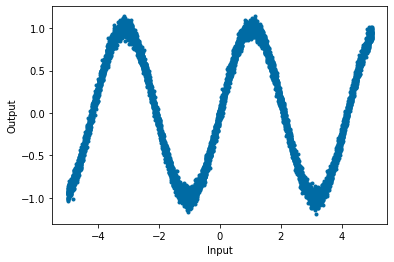

In [48]:
train_data = sample_input(sinusoid, 10000, 5., frequency=1.5, noise=0.05)
test_data = sample_input(sinusoid, 100, 5., frequency=1.5)

plot_sample(train_data)

We train the model.

In [49]:
model.reset_state()
train_model(model, criterion, optim, train_data)

100%|██████████| 25/25 [00:09<00:00,  2.74it/s, epoch=25, loss=11.2]


...and test the trained model by evaluating it on the the test data.

In [50]:
loss, predictions = eval_model(model, criterion, test_data)

In [51]:
grader.check("model_reduces_loss")

All tests passed!

We can see how well the model works by plotting the test data (circles) along with the predicted values (crosses).

In [52]:
def visualize_predictions(data, predictions):
    X, Y = data
    
    # Plot the actual output values
    plt.plot(X.tolist(), Y.tolist(), '.', label = 'Target Values')
    
    # Plot the predicted output values
    predictions = predictions.view(-1, 1)
    plt.plot(X.tolist(), predictions.tolist(), 'x', label = 'Predictions')
    
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()
    # we cannot use plt.show() because otter-grader does not support it

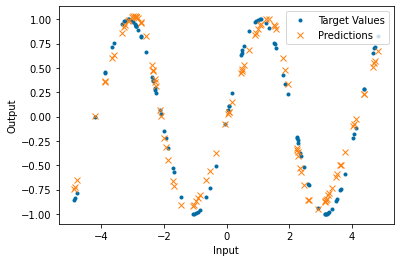

In [53]:
# Visualize the predictions
visualize_predictions(test_data, predictions)

## Trying different models

Now that we have the infrastructure, try experimenting with different models. Here are a few things you might play with. (No need to try them all.) What happens if you change the hidden dimension, increasing it to 8 or decreasing it to 2? What happens if you drop the middle layer? What about no middle layer but a much higher hidden dimension size? Does running for more epochs improve performance? Does the SGD optimizer work better or worse than the Adam optimizer?

**Perform any experimentation in cells below this point, so you don't modify the cells above that are being unit tested.**

100%|██████████| 25/25 [00:09<00:00,  2.60it/s, epoch=25, loss=1.85]


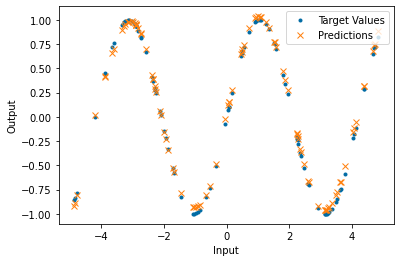

In [56]:
model = FFNN(8).to(device)
model.reset_state()
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_model(model, criterion, optim, train_data)

loss, predictions = eval_model(model, criterion, test_data)

visualize_predictions(test_data, predictions)

100%|██████████| 100/100 [00:23<00:00,  4.24it/s, epoch=100, loss=7.25]


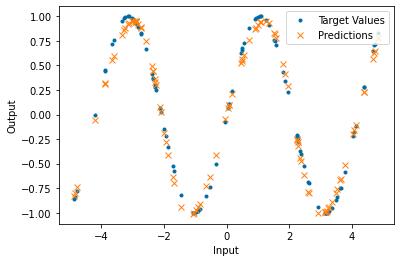

In [70]:
model = FFNN(HIDDEN_DIMENSION).to(device)
model.reset_state()
optim = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE*7)

train_model(model, criterion, optim, train_data, n_epochs=100)

loss, predictions = eval_model(model, criterion, test_data)

visualize_predictions(test_data, predictions)

<!-- BEGIN QUESTION -->

**Question:** What conclusions have you drawn from your experimentation?
<!--
BEGIN QUESTION
name: open_response_testing_models
manual: true
-->

_When using higher hidden dimensions we can achieve better results (for the same number of layers). As for smaller hidden dimensions we get the opposite. We also tried to learn with SGD instead of Adam, and it seems to learn slower, since for the same results we needed more epochs and faster learning rate._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Lab debrief

**Question:** We're interested in any thoughts you have about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 1-5

the labs length was right length. 
The readings was appropriate for the lab, but should've provided more in order to understand the interface. 
 it was clear after completing the labs, yes.
Are there additions or changes you think would make the lab better? We think this lab was really confusing, it was diffuclt to understand what we should do, or how to use different modules, since there was little explanation and little documentation of pytorch.

To double-check your work, the cell below will rerun all of the autograder tests.

In [71]:
grader.check_all()

FFNN:

    All tests passed!
    

count_instances:

    All tests passed!
    

count_instances_class:

    All tests passed!
    

count_tokens_instances:

    All tests passed!
    

dataset_setup:

    All tests passed!
    

dataset_split:

    All tests passed!
    

fields_setup:

    All tests passed!
    

model_reduces_loss:

    All tests passed!
    

print_vocab:

    All tests passed!
    

vocab_sizes:

    All tests passed!